In [ ]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import glob
from skimage import io
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [ ]:
print(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"))

In [ ]:
dir_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
# lets see one of the pneumonia image from train data
os.listdir(dir_path+'/train/PNEUMONIA')[:4]

In [ ]:
sample_img = load_img(dir_path+'/train/PNEUMONIA/person498_bacteria_2102.jpeg')
sample_img

## DATA PREPARATION:
## Lets progressively load the train, validation and test data using the ImageDataGenerator of keras.

In [ ]:
# Lets initiate the imagedatagenerator
datagen = ImageDataGenerator()

In [ ]:
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size, class_mode='binary')
valid_generator = datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size, class_mode='binary')
test_generator = datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size, class_mode='binary')

- From above we can see:
- There are total 5216 images in training data.
- There are total 16 images in validation data which is low.
- There are total 624 images in the testing data.

In [ ]:
train_len = 5216
val_len = 16
test_len = 624

In [ ]:
batchX, batchY = train_generator.next()

In [ ]:
print(batchX.shape)
print(batchY.shape)
print(np.unique(batchY))

- As we can see from above:
- the first batch of training data contains total 32 images with 256 by 256 size
- Also the batchY have only 0 and 1 values in which:
    - 0 represents Normal
    - 1 represents PNEUMONIA according to there alphebatical orders(keras conventions)

# Base Model:

In [ ]:
# lets first import all the necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [ ]:
# lets build very basic model
def def_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# lets compile our model
model = def_model()

In [ ]:
model.summary()

In [ ]:
# lets train our model now:
early_stopping_monitor = EarlyStopping(patience=2) 
history = model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor])
model.save_weights('first_try.h5')

In [ ]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

- As we can see with this simple model we are getting validation accuracy of 0.5 and train accuracy of 0.744
- Lets try to improve our model further and lets see whether it improves or not.

In [ ]:
from sklearn.utils import class_weight

In [ ]:
train_labels = train_generator.labels
unique_labels = np.unique(train_labels)

In [ ]:
import seaborn as sns

In [ ]:
sns.countplot(train_labels);
plt.xlabel('case type');
plt.ylabel('number of cases');

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 unique_labels,
                                                 train_labels)
class_weight_dict = dict(enumerate(class_weights))

- From above we can see out data is imbalance and number of normal cases are less than pneumonia cases in our train dataset.
- So lets try to implement class_weights and see whether our model performance improves.

In [ ]:
class_weight_dict

In [ ]:
from keras.optimizers import adam

In [ ]:
#lets change our model and see if it improves
def three_conv_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model.summary()

In [ ]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(64, 64))

In [ ]:
mul_conv_model = three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
mul_conv_history = mul_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

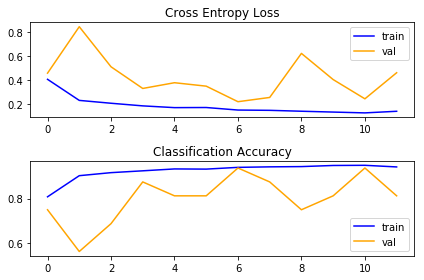

In [109]:
summarize_diagnostics(mul_conv_history)

In [114]:
_, acc = mul_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using convolution neural networks is {acc * 100.0}%')

accuracy on test data using convolution neural networks is 88.46153846153845%


## Lets try using pretrained vgg16 model now

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD, Nadam
from keras.models import Model

In [ ]:
def define_vggmodel():
    # load model
    model = VGG16(include_top=False, input_shape=(64, 64, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
vgg_model = define_vggmodel()
vgg_early_stopping_monitor = EarlyStopping(patience=5) 
vgg_history = vgg_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [vgg_early_stopping_monitor],\
                   class_weight=class_weight_dict)

In [ ]:
import sys
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='orange', label='val')
    plt.legend()
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.tight_layout()
    plt.show()

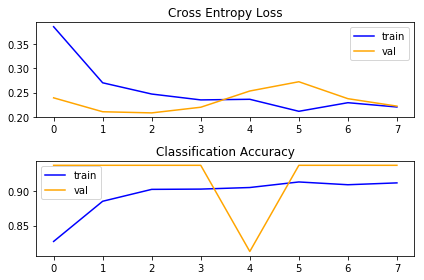

In [110]:
summarize_diagnostics(vgg_history)

In [112]:
_, acc = vgg_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using pretrained vgg model is {acc * 100.0}')

accuracy on test data using pretrained vgg model is 89.26282051282051


- lets add more layers in the end and see if the model is improving.

In [ ]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(128, 128))

In [116]:
def improved_three_conv_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [117]:
improve_mul_conv_model = improved_three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
impr_mul_conv_history = improve_mul_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

Epoch 1/100
326/326 [==============================] - 72s 220ms/step - loss: 0.4044 - acc: 0.8060 - val_loss: 0.7636 - val_acc: 0.7500
Epoch 2/100
326/326 [==============================] - 68s 210ms/step - loss: 0.2451 - acc: 0.8877 - val_loss: 0.3127 - val_acc: 0.9375
Epoch 3/100
326/326 [==============================] - 68s 209ms/step - loss: 0.2225 - acc: 0.9022 - val_loss: 0.2701 - val_acc: 0.8750
Epoch 4/100
326/326 [==============================] - 69s 210ms/step - loss: 0.1848 - acc: 0.9229 - val_loss: 0.4346 - val_acc: 0.8125
Epoch 5/100
326/326 [==============================] - 70s 213ms/step - loss: 0.1869 - acc: 0.9235 - val_loss: 0.4424 - val_acc: 0.7500
Epoch 6/100
326/326 [==============================] - 68s 209ms/step - loss: 0.1605 - acc: 0.9327 - val_loss: 0.5448 - val_acc: 0.6875
Epoch 7/100
326/326 [==============================] - 68s 209ms/step - loss: 0.1670 - acc: 0.9316 - val_loss: 0.2591 - val_acc: 0.8750
Epoch 8/100
326/326 [===========================

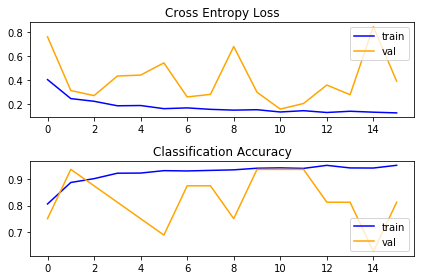

In [118]:
summarize_diagnostics(impr_mul_conv_history)

In [119]:
_, acc = improve_mul_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using improved convolution neural networks is {acc * 100.0}%')

accuracy on test data using improved convolution neural networks is 91.50641025641025%


- Lets try to further improve our cnn network

In [124]:
def further_improved_three_conv_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [122]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(128, 128))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(128, 128))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [125]:
further_imp_conv_model = further_improved_three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
further_impr_mul_conv_history = further_imp_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

Epoch 1/100
326/326 [==============================] - 85s 261ms/step - loss: 0.4448 - acc: 0.7845 - val_loss: 0.7231 - val_acc: 0.6875
Epoch 2/100
326/326 [==============================] - 82s 252ms/step - loss: 0.2653 - acc: 0.8829 - val_loss: 0.5354 - val_acc: 0.8125
Epoch 3/100
326/326 [==============================] - 83s 253ms/step - loss: 0.2425 - acc: 0.8957 - val_loss: 1.6414 - val_acc: 0.6875
Epoch 4/100
326/326 [==============================] - 82s 252ms/step - loss: 0.2139 - acc: 0.9061 - val_loss: 0.8532 - val_acc: 0.6250
Epoch 5/100
326/326 [==============================] - 82s 251ms/step - loss: 0.2088 - acc: 0.9156 - val_loss: 1.2486 - val_acc: 0.6875
Epoch 6/100
326/326 [==============================] - 83s 253ms/step - loss: 0.1923 - acc: 0.9178 - val_loss: 0.5041 - val_acc: 0.6875
Epoch 7/100
326/326 [==============================] - 82s 252ms/step - loss: 0.1863 - acc: 0.9141 - val_loss: 0.9713 - val_acc: 0.6875
Epoch 8/100
326/326 [===========================

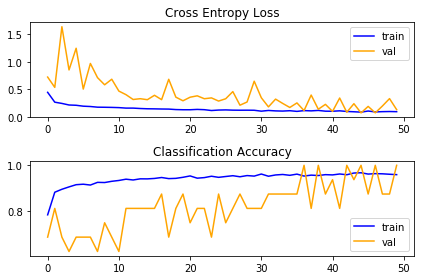

In [126]:
summarize_diagnostics(further_impr_mul_conv_history)

In [193]:
test_loss, acc = further_imp_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using further improved convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using further improved convolution neural networks is {test_loss}')

accuracy on test data using further improved convolution neural networks is 94.07051282051282%
test loss on test data using further improved convolution neural networks is 0.20237024431713882


In [130]:
# lets save the weights
further_imp_conv_model.save_weights('best_cnn_weights.h5')

In [131]:
further_imp_conv_model.save("further_improved_cnn_model.h5")

In [132]:
os.listdir()

['first_try.h5',
 'best_cnn_weights.h5',
 'further_improved_cnn_model.h5',
 'ipykernel_launcher.py_plot.png',
 '.ipynb_checkpoints',
 '__notebook_source__.ipynb']

In [194]:
test_generator.reset()

In [201]:
test_generator.reset()

In [202]:
batch_x, batch_y = test_generator.next()

In [205]:
test_generator.batch_index

1

In [210]:
aa = []
aa.extend(list(batch_y))

In [218]:
test_generator.reset()
test_predict_proba = []
test_actual = []
for itr in range(len(test_generator)):
    b_x, b_y = test_generator.next()
    pre_list = list(further_imp_conv_model.predict_on_batch(b_x)[:,0])
    test_predict_proba.extend(pre_list)
    test_actual.extend(list(b_y))
    print(itr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [190]:
test_actual_values = test_generator.classes

In [158]:
import scikitplot as skplt

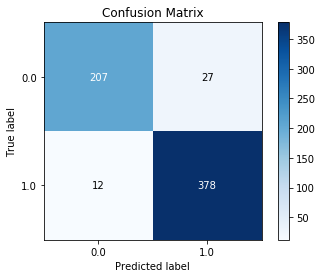

In [223]:
skplt.metrics.plot_confusion_matrix(np.array(test_actual), np.round(test_predict_proba));

In [173]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [224]:
accuracy_score(np.array(test_actual), np.round(test_predict_proba))

0.9375

In [225]:
print(classification_report(np.array(test_actual), np.round(test_predict_proba), target_names=['Normal', 'PNEUMONIA']))

              precision    recall  f1-score   support

      Normal       0.95      0.88      0.91       234
   PNEUMONIA       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



- As we can see We got a very good recall rate of 0.97 on PNEUMONIA with a precision of 0.93.
- Normally in the medical test cases recall rate is very important, we should not label a pneumonia patient as normal which puts the person in danger.
- So by using our deep learning model we got a good recall rate as well as with good precision.
- our weighted average f1-score is 0.94 which is very good.